<font color="green">**Temporal data analysis and drift plotting using temporal data**</font>

**Import libraries**

In [ ]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

**Read stock data and visualize**

In [ ]:
#Get the stock quote 
df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-05-26')

#To get stock quote for Apple, Tesla, Disney=>Uncomment required line below
#df = web.DataReader('AAPL', data_source='yahoo', start='2016-07-22', end='2020-10-30') 
#df = web.DataReader('DIS', data_source='yahoo', start='2016-07-22', end='2020-10-30')
#df = web.DataReader('TSLA', data_source='yahoo', start='2016-07-22', end='2020-10-30')

#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,33.459999,32.470001,32.900002,32.869999,1637000,32.869999
2016-07-25,33.099998,32.500000,32.959999,32.599998,540600,32.599998
2016-07-26,32.730000,31.830000,32.540001,32.549999,802000,32.549999
2016-07-27,33.520000,32.790001,32.980000,33.209999,856900,33.209999
2016-07-28,34.570000,33.430000,33.509998,34.270000,1046900,34.270000


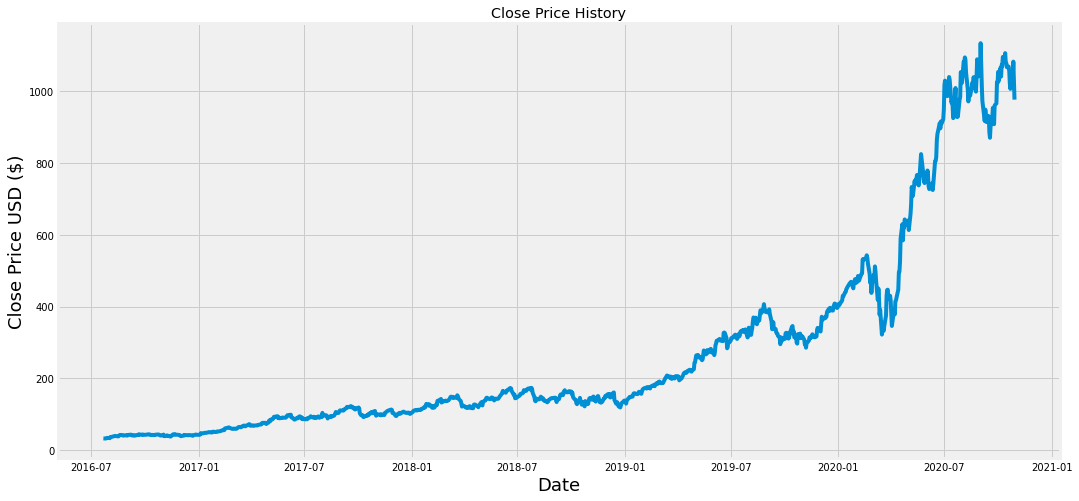

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Preprocess stock data and split into train-test dataset**

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [ ]:
scaled_data[1]

array([4.53808322e-05])

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [ ]:
y_train[1]

0.00901277107053556

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
#scaled_data = scaler.fit_transform(dataset)
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

**Build model and train on training data**

In [ ]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#model.compile(optimizer='adam',loss='mean_absolute_error')

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Train the model
#model.fit(x_train, y_train, batch_size=1, epochs=1)
model.fit(x_train,  y_train, batch_size=1, epochs=1)

802/802 [==============================] - 17s 22ms/step - loss: 5.3817e-04


In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

**Predict on testing data and visualize predictions**

In [ ]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
preds=predictions
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [ ]:
print(predictions[0])

[393.7037]


In [ ]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

60.303013819585125

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


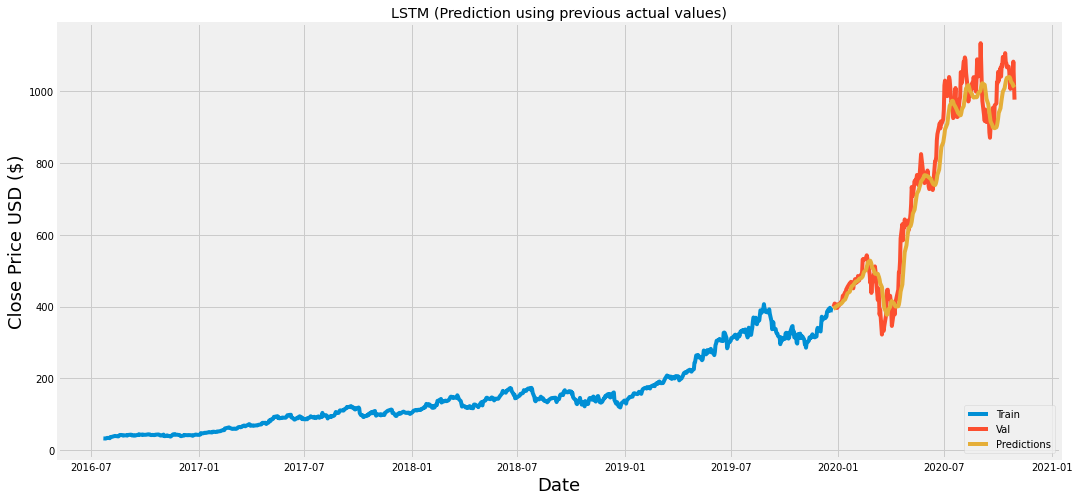

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('LSTM (Prediction using previous actual values)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<font color="green">**Drift detection**</font>

In [ ]:
#mean absolute error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(y_test, predictions)
mae

1.8345663831641636

In [ ]:
#Find drift data
df1=df.reset_index()
datelist=[]
for i in range(len(y_test)):
  diff=abs(y_test[i]-predictions[i])
  if(diff>(mae+2.5)):
    #print(df1.loc[training_data_len+i,"Date"])
    datelist.append(df1.loc[training_data_len+i,"Date"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


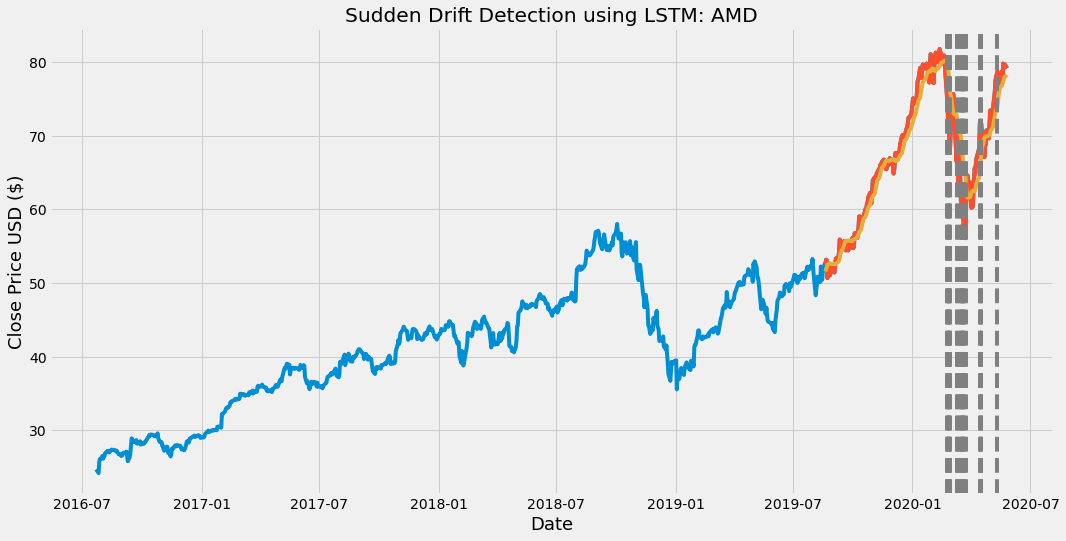

In [ ]:
#Plot graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Sudden Drift Detection using LSTM: AMD')
plt.plot(df1['Date'],df1['Close'])
plt.plot(valid[['Close', 'Predictions']])
for i in range(len(datelist)):
  plt.axvline(pd.Timestamp(datelist[i]),color='gray',linestyle='--')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

<font color="green">**Temporal analysis**</font>

**Read vector data and preprocess**

In [ ]:
#Read vector data from file
vectorsdf=pd.read_csv("vectorAMD.csv")
vectorsdf.head(2)

,date,news,vectors,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9,vec10,vec11,vec12,vec13,vec14,vec15,vec16,vec17,vec18,vec19,vec20,vec21,vec22,vec23,vec24,vec25,vec26,vec27,vec28,vec29,vec30,vec31,vec32,vec33,vec34,vec35,vec36,...,vec260,vec261,vec262,vec263,vec264,vec265,vec266,vec267,vec268,vec269,vec270,vec271,vec272,vec273,vec274,vec275,vec276,vec277,vec278,vec279,vec280,vec281,vec282,vec283,vec284,vec285,vec286,vec287,vec288,vec289,vec290,vec291,vec292,vec293,vec294,vec295,vec296,vec297,vec298,vec299
0,2020-05-26,BLICKNovartisAugenarznei Beovu kommt künftig a...,[ 5.07812500e-02 -3.95329781e-02 1.02132158e-...,0.050781,-0.039533,0.010213,-0.075195,-0.038859,0.104736,0.194661,-0.186890,-0.004395,0.226562,-0.172363,-0.138631,-0.053874,-0.110758,-0.088399,-0.058268,0.079976,0.237467,-0.072428,0.016398,-0.08724,0.154297,0.150391,0.095378,-0.157715,-0.113200,-0.075765,0.18457,-0.131673,-0.199056,0.144531,-0.018026,-0.070312,-0.266602,-0.110677,-0.177897,-0.033723,...,0.059896,0.205729,0.191081,-0.025960,-0.053304,0.165365,0.037242,-0.040446,-0.010254,0.027181,0.030843,-0.072266,-0.121501,0.011556,0.185465,0.033366,-0.189453,0.184408,-0.291016,0.193522,-0.128255,0.064046,0.050374,0.033203,-0.097377,0.129021,0.144938,-0.028564,-0.152262,0.011149,-0.065104,-0.025411,-0.240885,0.204753,-0.058431,-0.012370,-0.157552,0.032389,0.049072,0.152181
1,2020-05-19,Brazil stock exchange B3 operation despite hol...,[-0.00317383 0.05178223 -0.00095215 -0.041371...,-0.003174,0.051782,-0.000952,-0.041371,0.044580,-0.038391,-0.029260,-0.202637,0.105780,0.057080,0.004889,-0.091910,0.007547,0.161700,-0.099097,0.063708,0.009985,0.104175,0.017120,0.007758,0.07345,-0.041113,0.013174,-0.018564,0.076413,-0.085272,0.001062,-0.03020,-0.016718,0.037366,-0.003046,-0.101477,-0.018640,0.046960,-0.036743,-0.037891,-0.011987,...,0.106567,0.027048,0.079728,0.096387,0.063635,0.088950,-0.097095,-0.006531,-0.148611,0.047131,-0.107397,-0.072119,0.014468,-0.069873,0.025391,-0.083803,-0.066479,-0.043561,0.008105,0.067792,-0.049259,0.059497,-0.057251,-0.009552,0.018744,-0.035931,-0.017302,0.041388,-0.058539,-0.058434,-0.064038,0.020288,-0.015991,0.041321,0.051868,0.066577,-0.041785,-0.011420,0.010396,0.005371


In [ ]:
vectorsdf1=vectorsdf[['vec0','vec1']]
outdf=vectorsdf
vectorsdf1.head(2)

,vec0,vec1
0,0.050781,-0.039533
1,-0.003174,0.051782


**Compute kl divergence and jenson shannon distance on vectors data**

In [ ]:
#Function for kl-divergence
from math import log2
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

In [ ]:
#Create columns for distances
outdf['kl-divergence']=0
outdf['jenson-shanon']=0

In [ ]:
#Compute jenson-shannon distance
from scipy.spatial.distance import jensenshannon
import scipy.stats
for i in range(len(vectorsdf)-1):
  curr=vectorsdf1.iloc[i].values
  next=vectorsdf1.iloc[i+1].values
  #curr_list = np.array(curr)
  #next_list = np.array(next)
  m = (curr + next) / 2
  divergence = (scipy.stats.entropy(curr, m) + scipy.stats.entropy(next, m)) / 2
  distance = np.sqrt(divergence)
  outdf.loc[i,"kl-divergence"]=distance
  outdf.loc[i,"jenson-shanon"]=jensenshannon(curr, next, base=2)

In [ ]:
outdf.head(2)

,date,news,vectors,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9,vec10,vec11,vec12,vec13,vec14,vec15,vec16,vec17,vec18,vec19,vec20,vec21,vec22,vec23,vec24,vec25,vec26,vec27,vec28,vec29,vec30,vec31,vec32,vec33,vec34,vec35,vec36,...,vec262,vec263,vec264,vec265,vec266,vec267,vec268,vec269,vec270,vec271,vec272,vec273,vec274,vec275,vec276,vec277,vec278,vec279,vec280,vec281,vec282,vec283,vec284,vec285,vec286,vec287,vec288,vec289,vec290,vec291,vec292,vec293,vec294,vec295,vec296,vec297,vec298,vec299,kl-divergence,jenson-shanon
0,2020-05-26,BLICKNovartisAugenarznei Beovu kommt künftig a...,[ 5.07812500e-02 -3.95329781e-02 1.02132158e-...,0.050781,-0.039533,0.010213,-0.075195,-0.038859,0.104736,0.194661,-0.186890,-0.004395,0.226562,-0.172363,-0.138631,-0.053874,-0.110758,-0.088399,-0.058268,0.079976,0.237467,-0.072428,0.016398,-0.08724,0.154297,0.150391,0.095378,-0.157715,-0.113200,-0.075765,0.18457,-0.131673,-0.199056,0.144531,-0.018026,-0.070312,-0.266602,-0.110677,-0.177897,-0.033723,...,0.191081,-0.025960,-0.053304,0.165365,0.037242,-0.040446,-0.010254,0.027181,0.030843,-0.072266,-0.121501,0.011556,0.185465,0.033366,-0.189453,0.184408,-0.291016,0.193522,-0.128255,0.064046,0.050374,0.033203,-0.097377,0.129021,0.144938,-0.028564,-0.152262,0.011149,-0.065104,-0.025411,-0.240885,0.204753,-0.058431,-0.012370,-0.157552,0.032389,0.049072,0.152181,inf,inf
1,2020-05-19,Brazil stock exchange B3 operation despite hol...,[-0.00317383 0.05178223 -0.00095215 -0.041371...,-0.003174,0.051782,-0.000952,-0.041371,0.044580,-0.038391,-0.029260,-0.202637,0.105780,0.057080,0.004889,-0.091910,0.007547,0.161700,-0.099097,0.063708,0.009985,0.104175,0.017120,0.007758,0.07345,-0.041113,0.013174,-0.018564,0.076413,-0.085272,0.001062,-0.03020,-0.016718,0.037366,-0.003046,-0.101477,-0.018640,0.046960,-0.036743,-0.037891,-0.011987,...,0.079728,0.096387,0.063635,0.088950,-0.097095,-0.006531,-0.148611,0.047131,-0.107397,-0.072119,0.014468,-0.069873,0.025391,-0.083803,-0.066479,-0.043561,0.008105,0.067792,-0.049259,0.059497,-0.057251,-0.009552,0.018744,-0.035931,-0.017302,0.041388,-0.058539,-0.058434,-0.064038,0.020288,-0.015991,0.041321,0.051868,0.066577,-0.041785,-0.011420,0.010396,0.005371,inf,inf


**Compute and plot cosine similarity between vectors data**

In [ ]:
#Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(vectorsdf1, vectorsdf1))
cs=cosine_similarity(vectorsdf1, vectorsdf1)

[[ 1.         -0.66141628 -0.38217791 ...  0.63160206 -0.71532015
  -0.88530533]
 [-0.66141628  1.         -0.44030544 ...  0.16373241  0.99723533
   0.23678887]
 [-0.38217791 -0.44030544  1.         ... -0.95782367 -0.37237079
   0.76805484]
 ...
 [ 0.63160206  0.16373241 -0.95782367 ...  1.          0.08997448
  -0.91967969]
 [-0.71532015  0.99723533 -0.37237079 ...  0.08997448  1.
   0.30832906]
 [-0.88530533  0.23678887  0.76805484 ... -0.91967969  0.30832906
   1.        ]]


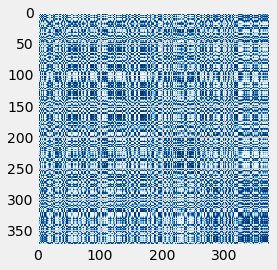

In [ ]:
#Plot cosine similarity
plt.imshow(cs,interpolation='none',cmap='Blues')

**Get semantic scores and preprocess**

In [ ]:
#Read data from file
semanticdf=pd.read_csv("amd-all-scores.csv")
semanticdf.head(2)

,date,subjectivity,polarity,entropy,flesch_index,dale_chall_index,final_semantic_score
0,2016-07-22,0.417751,0.133707,7.207807,50.3,13.015,0.291504
1,2016-07-23,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Impute missing values
semanticdf=semanticdf.ffill(axis=0)
semanticdf.head(2)

,date,subjectivity,polarity,entropy,flesch_index,dale_chall_index,final_semantic_score
0,2016-07-22,0.417751,0.133707,7.207807,50.3,13.015,0.291504
1,2016-07-23,0.417751,0.133707,7.207807,50.3,13.015,0.291504


In [ ]:
#Convert to required format
semanticdf['date'] = pd.to_datetime(semanticdf['date'])

**Visualize drifts and semantic score plot**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """


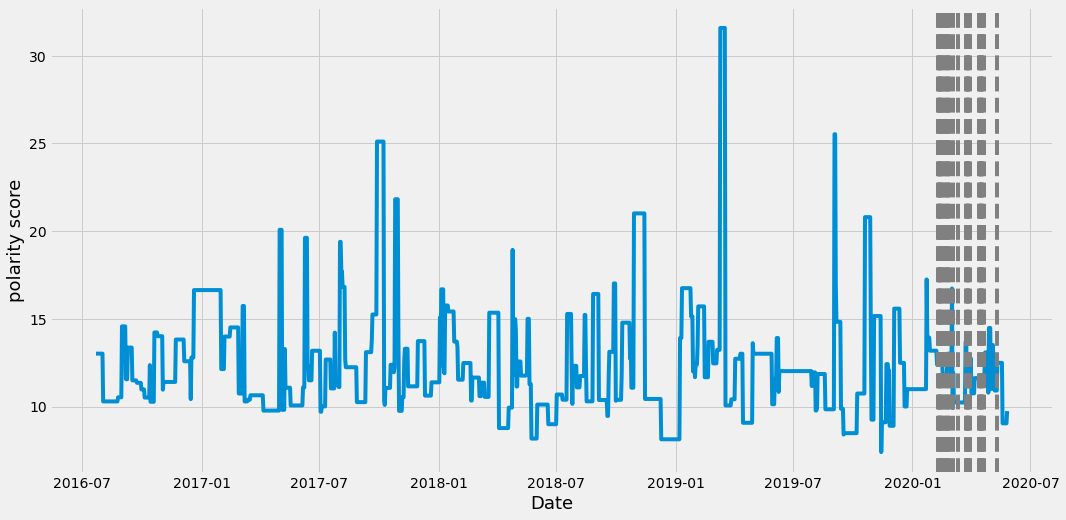

In [ ]:
#Plot graph
plt.figure(figsize=(16,8))
plt.plot(semanticdf['date'],semanticdf['dale_chall_index'])
#plt.plot(valid[['Close', 'Predictions']])
for i in range(len(datelist)):
  plt.axvline(pd.datetime.date(datelist[i]),color='gray',linestyle='--')
plt.xlabel('Date',fontsize=18)
plt.ylabel('polarity score',fontsize=18)
plt.show()